<h2> 1) Import and install Dependencies <h2>

<h3> 1.1) Install Dependencies

In [1]:
# !pip install tensorflow tensorflow-gpu tensorflow-io matplotlib 

<h3> 1.2) Load Dependencies

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
# Avoid OOM errors
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

<h2> 2) Build Data Loading Function <h3>

<h3> 2.1) Define Paths to files

In [4]:
CAPUCHIN_FILE = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [5]:
CAPUCHIN_FILE

'../input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC3776-3.wav'

<h3> 2.2) Build Dataloading Function

In [6]:
def load_wav_16k_mono(filename):
#     Load encoded wav file
    file_contents = tf.io.read_file(filename)
#     Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     Remove trailing axis
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     Convert from 441khz to 16khz(Aimplitude of the audio signal)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav

<h3> 2.3) Plot Wave

In [7]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

2022-09-17 11:04:44.251224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 11:04:44.352249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 11:04:44.353267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 11:04:44.355756: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

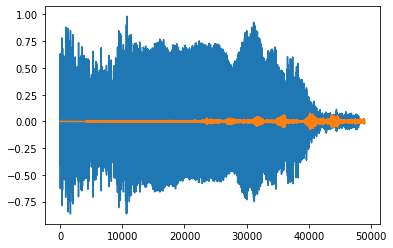

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

<h2> 3) Create Tensorflow Dataset <h3>

<h3> 3.1) Create paths to Positive and Negative data

In [9]:
POS = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Parsed_Not_Capuchinbird_Clips') 

In [10]:
POS

'../input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'

<h3> 3.2) Create Tensorflow Datasets

In [11]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [12]:
# pos.as_numpy_iterator().next()

<h3> 3.3) Add labels and Combine Positive and Negative Samples

In [13]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [14]:
# data.as_numpy_iterator().next()

<h2> 4) Determine Average Length of a Capuchin call <h3>

<h3> 4.1) Calculate Wave Cycle Length

In [15]:
# lengths = []
# for file in os.listdir(os.path.join('datasets', 'Parsed_Capuchinbird_Clips')):
#     tensor_wave = load_wav_16k_mono(os.path.join('datasets', 'Parsed_Capuchinbird_Clips', file))
#     lengths.append(len(tensor_wave))

In [16]:
# lengths[:5]

<h3> 4.2) Calculate Mean, Min and Max

In [17]:
# tf.math.reduce_mean(lengths)
# Average duration of bird call = 54156\16000 = 3.38475

In [18]:
# tf.math.reduce_min(lengths)

In [19]:
# tf.math.reduce_max(lengths)

<h2> 5) Build Preprocessing function to convert to Spectogram <h3>

<h3> 5.1) Build Preprocessing Function

In [20]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    
#     Use short time Fourier transform(stft) to convert to a spectogram
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    
    return spectogram, label

<h3> 5.2) Test out the function and Visualize the Spectogram

In [21]:
# filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [22]:
# spectogram, label = preprocess(filepath, label)

In [23]:
# plt.figure(figsize=(30,20))
# plt.imshow(tf.transpose(spectogram)[0])
# plt.show()

<h2> 6) Create Training and Testing Partitions <h3>

<h3> 6.1) Create a Tensorflow Data Pipeline

In [24]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

<h3> 6.2) Split into Training and Testing Partitions

In [25]:
len(data)

51

In [26]:
train = data.take(36)     #70% of data
test = data.skip(36).take(15)

<h3> 6.3) Test One Batch

In [27]:
# samples, labels = train.as_numpy_iterator().next()

In [28]:
# samples.shape

In [29]:
# labels

<h2> 7) Build Deep learning Model <h3>

<h3> 7.1) Load Tensorflow Dependencies

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

<h3> 7.2) Build Sequential Model, compile and View summary

In [31]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
# Add a max pooling layer if you want to reduce the number of trainable parameters
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 16)     160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1487, 253, 16)     2320      
_________________________________________________________________
flatten (Flatten)            (None, 6019376)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               770480256 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


<h3> 7.3) Fit Model, View Loss and KPI Plots

In [34]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2022-09-17 11:05:00.627035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 192 of 1000
2022-09-17 11:05:10.583252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 369 of 1000
2022-09-17 11:05:20.644044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 536 of 1000
2022-09-17 11:05:30.669844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 713 of 1000
2022-09-17 11:05:35.843862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-09-17 11:05:36.739703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - 61s 221ms/step - loss: 2.1999 - recall: 0.8129 - precision: 0.8077 - val_loss: 0.0018 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/4
36/36 [==============================] - 7s 208ms/step - loss: 0.0814 - recall: 0.9871 - precision: 0.9745 - val_loss: 0.3202 - val_recall: 1.0000 - val_precision: 0.9841
Epoch 3/4
36/36 [==============================] - 7s 206ms/step - loss: 0.1687 - recall: 0.9521 - precision: 0.9720 - val_loss: 0.0170 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 7s 208ms/step - loss: 0.0364 - recall: 0.9859 - precision: 0.9722 - val_loss: 0.0618 - val_recall: 0.9545 - val_precision: 1.0000


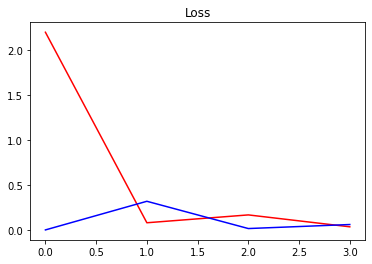

In [35]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

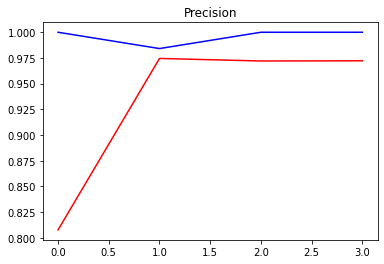

In [36]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

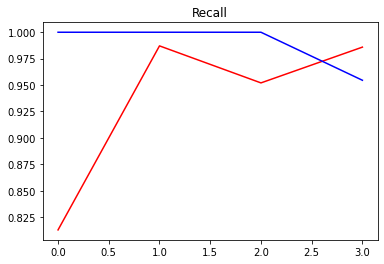

In [37]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [38]:
# model.save('deep_audio_classifier.h5')

<h2> 8) Make a prediction on a single clip <h3>

<h3> 8.1) Get One Batch and Make a Prediction

In [39]:
X_test, y_test = test.as_numpy_iterator().next()

In [40]:
yhat = model.predict(X_test)

In [41]:
yhat

array([[1.0000000e+00],
       [1.0000000e+00],
       [9.6604204e-35],
       [2.9757498e-15],
       [1.0000000e+00],
       [6.0289147e-28],
       [7.6230836e-12],
       [1.3187559e-09],
       [3.9025978e-04],
       [6.8307110e-11],
       [1.0000000e+00],
       [0.0000000e+00],
       [5.2455422e-16],
       [1.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00]], dtype=float32)

<h3> 8.2) Convert Logits to Classes

In [42]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [43]:
yhat

[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]

In [44]:
y_test.astype(int)

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

<h2> 9) Build Forest Parsing Functions <h3>

<h3> 9.1) Load uo MP3s

In [45]:
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
#     Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis =1) / 2
    
#     Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
#     Resample to 16khz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [46]:
mp3 = '../input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3'

In [47]:
wav = load_mp3_16k_mono(mp3)

In [48]:
# Slice the full audio into small size slices same as need for prediction and carry out multiple predictions per audio clip
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [50]:
samples, index = audio_slices.as_numpy_iterator().next()

In [51]:
samples.shape

(1, 48000)

<h3> 9.2) Build Function to Convert Clips into Windowed Spectograms

In [52]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    
    return spectogram

<h3> 9.3) Convert Longer audio clips into Windows and Make predictions

In [53]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [57]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

In [58]:
len(yhat)

60

<h3> 9.4) Group Consecutive Detections

In [56]:
# Since the audio clip is sliced we get consecutive detections
from itertools import groupby

In [59]:
yhat = [key for key, group in groupby(yhat)]

In [60]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [62]:
calls = tf.math.reduce_sum(yhat).numpy()
calls

5

<h2> 10) Make Predictions <h3>

<h3> 10.1) Loopover all recordings and make predictions

In [65]:
results = {}
dir_path = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings')

for file in os.listdir(dir_path):
    FILEPATH = os.path.join('../input/z-by-hp-unlocked-challenge-3-signal-processing', 'Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [66]:
results

{'recording_76.mp3': array([[4.9083917e-11],
        [3.9367857e-16],
        [8.4788957e-07],
        [5.6596326e-07],
        [1.6257056e-06],
        [7.2784934e-07],
        [1.8380662e-06],
        [1.6494747e-06],
        [4.2346755e-07],
        [8.2221268e-06],
        [6.6631346e-06],
        [1.2229277e-05],
        [6.7898632e-06],
        [3.8370716e-05],
        [3.7223470e-04],
        [1.4223502e-05],
        [5.7682992e-06],
        [3.6555357e-06],
        [6.8213863e-06],
        [1.1526139e-08],
        [1.8905020e-08],
        [1.5033953e-08],
        [5.4886755e-07],
        [2.0585377e-16],
        [7.4793531e-22],
        [3.7276241e-34],
        [1.0676126e-17],
        [3.0461750e-17],
        [3.4094582e-18],
        [8.3479681e-20],
        [1.8959390e-28],
        [8.9392160e-13],
        [5.1043972e-26],
        [3.8944828e-17],
        [3.5323839e-14],
        [1.1180366e-19],
        [6.7272340e-19],
        [9.6712196e-21],
        [4.4941122e-14],
     

<h3> 10.2) Convert Predictions into Classes

In [67]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

class_preds

{'recording_76.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_62.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_48.mp3': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_44.mp3': [0,
  0,
  0,
  

In [71]:
import numpy as np

<h3> 10.3) Group Consecutive Detections

In [72]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = np.sum([key for key, group in groupby(scores)])
    
postprocessed

{'recording_76.mp3': 0,
 'recording_62.mp3': 0,
 'recording_48.mp3': 3,
 'recording_44.mp3': 1,
 'recording_45.mp3': 3,
 'recording_06.mp3': 5,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 5,
 'recording_17.mp3': 3,
 'recording_65.mp3': 4,
 'recording_74.mp3': 0,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 1,
 'recording_37.mp3': 3,
 'recording_64.mp3': 2,
 'recording_39.mp3': 13,
 'recording_04.mp3': 4,
 'recording_28.mp3': 12,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 3,
 'recording_12.mp3': 0,
 'recording_59.mp3': 10,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 14,
 'recording_86.mp3': 16,
 'recording_47.mp3': 14,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 25,
 'recording_51.mp3': 3,
 'recording_35.mp3': 0,
 'recording_81.mp3': 4,
 'recording_30.mp3': 3,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recordi

<h2> 11) Export results <h3>

In [69]:
import csv

In [73]:
with open('./capuchinBirds_results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])